# Object Detection API Demo

<table align="left"><td>
  <a target="_blank"  href="https://colab.sandbox.google.com/github/tensorflow/models/blob/master/research/object_detection/colab_tutorials/object_detection_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/object_detection_tutorial.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

Welcome to the [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection). This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image.

> **Important**: This tutorial is to help you through the first step towards using [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) to build models. If you just just need an off the shelf model that does the job, see the [TFHub object detection example](https://colab.sandbox.google.com/github/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb).

# Setup

Important: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md). This notebook includes only what's necessary to run in Colab.

### Install

In [1]:
!pip install -U --pre tensorflow=="2.3"
!pip install tf_slim

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.2.0-cp36-cp36m-manylinux2010_x86_64.whl (516.2 MB)
  Using cached tensorboard-2.2.2-py3-none-any.whl (3.0 MB)
  Using cached tensorflow_estimator-2.2.0-py2.py3-none-any.whl (454 kB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.3.1
    Uninstalling tensorflow-2.3.1:
      Successfully uninstalled tensorflow-2.3.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency confli

Make sure you have `pycocotools` installed

In [2]:
!pip install pycocotools

Defaulting to user installation because normal site-packages is not writeable


Get `tensorflow/models` or `cd` to parent directory of the repository.

In [54]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
    
    print("here")
    !git clone --depth 1 https://github.com/tensorflow/models

In [13]:
#check where you are
!pwd

/home/syslab3/Desktop/Tensorflow/models/research


In [6]:
#you must need to be there /Tensorflow/models/research/
cd models/research

/home/syslab3/Desktop/Tensorflow/models/research


Compile protobufs and install the object_detection package

In [8]:
%%bash
#cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [9]:
%%bash 
#cd models/research
pip install .

Defaulting to user installation because normal site-packages is not writeable
Processing /home/syslab3/Desktop/Tensorflow/models/research
  Using cached tensorflow-2.3.1-cp36-cp36m-manylinux2010_x86_64.whl (320.4 MB)
  Using cached tensorflow_estimator-2.3.0-py2.py3-none-any.whl (459 kB)
  Using cached tensorboard-2.4.0-py3-none-any.whl (10.6 MB)
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1597506 sha256=9d562e18fac5778d2a4b563f0bc74f7cf961566d76bb9e51c13bbba5d5969ff8
  Stored in directory: /tmp/pip-ephem-wheel-cache-5n7y2003/wheels/f2/08/dc/30da3a0cee2fb80e0edc25876f39c2b7ec8f723b459d37d129
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-

### Imports

In [10]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

Import the object detection module.

In [11]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

Patches:

In [12]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing the path.

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

## Loader

In [107]:
#1st download tensorflow/model repository from this link https://github.com/tensorflow/models
#2nd copy your training_demo/models/my_ssd_resnet50_v1_fpn and paste it into tensorflow/models/research/object_detection/
#3rd place your url in the base_url (it must be same like present url)
def load_model(model_name):
  base_url = 'https://github.com/MuhammadSaad20/models/tree/master/research/object_detection/'
  model_file = model_name 
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))

  return model

In [91]:
#check your location that you must be in tensorflow/models/research 
!pwd

/home/syslab3/Desktop/Tensorflow/models/research


## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [108]:
#copy your label_map.pbtxt file from annotation/ and paste it into models/research/object_detection/data/.
PATH_TO_LABELS = 'object_detection/data/object-detection.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [93]:
!pwd

/home/syslab3/Desktop/Tensorflow/models/research


For the sake of simplicity we will test on 2 images:

In [119]:
#If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
#add new images inside models/research/object_detection/test_images/ in which model is not trained
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('object_detection/test_images/image22.jpg'),
 PosixPath('object_detection/test_images/image3.jpg'),
 PosixPath('object_detection/test_images/image4.jpg'),
 PosixPath('object_detection/test_images/image5.jpg')]

In [95]:
!pwd

/home/syslab3/Desktop/Tensorflow/models/research


# Detection

Load an object detection model:

In [110]:
#copy your model from training_demo/models/ and paste it into your .keras folder ex: "home/.keras/datasets/"
#also copy your saved_model from training_demo/exported-models/ and paste into .keras/datasets/my_ssd_mobilenet_v2_fpnlite/
model_name = 'my_ssd_mobilenet_v2_fpnlite'        #specify your model name
detection_model = load_model(model_name)

In [ ]:
!pwd

Check the model's input signature, it expects a batch of 3-color images of type uint8:

In [111]:
print(detection_model.signatures['serving_default'].inputs)

[<tf.Tensor 'input_tensor:0' shape=(1, None, None, 3) dtype=uint8>, <tf.Tensor 'unknown:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_0:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_1:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_2:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_3:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_4:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_5:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_6:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_7:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_8:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_9:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_10:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_11:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_12:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_13:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_14:0' shape=<unknown> dtype=resource>, <

And returns several outputs:

In [112]:
detection_model.signatures['serving_default'].output_dtypes

{'detection_multiclass_scores': tf.float32,
 'detection_anchor_indices': tf.float32,
 'raw_detection_scores': tf.float32,
 'raw_detection_boxes': tf.float32,
 'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32}

In [113]:
detection_model.signatures['serving_default'].output_shapes

{'detection_multiclass_scores': TensorShape([1, 100, 2]),
 'detection_anchor_indices': TensorShape([1, 100]),
 'raw_detection_scores': TensorShape([1, 51150, 2]),
 'raw_detection_boxes': TensorShape([1, 51150, 4]),
 'detection_boxes': TensorShape([1, 100, 4]),
 'detection_classes': TensorShape([1, 100]),
 'detection_scores': TensorShape([1, 100]),
 'num_detections': TensorShape([1])}

Add a wrapper function to call the model, and cleanup the outputs:

In [114]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

Run it on each test image and show the results:

In [115]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

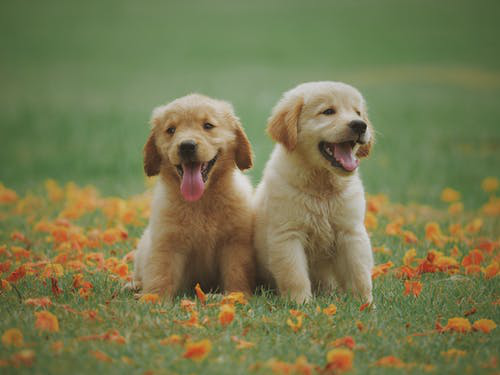

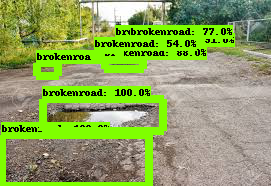

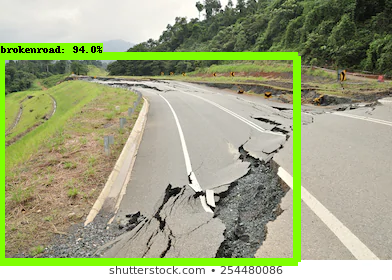

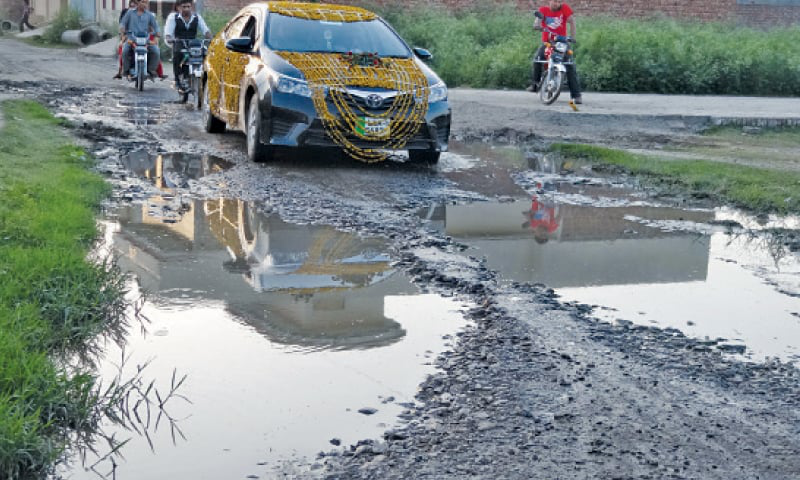

In [120]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)


## Instance Segmentation

In [ ]:
model_name = "mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28"
masking_model = load_model(model_name)

The instance segmentation model includes a `detection_masks` output:

In [ ]:
masking_model.output_shapes

In [ ]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(masking_model, image_path)